In [1]:
import pickle
import numpy as np
import pandas as pd
import math as mt
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input, concatenate
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
import xgboost as xgb
from tqdm import tqdm
%matplotlib inline

ModuleNotFoundError: No module named 'keras'

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 232079837288522497
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1254227968
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2716945692826012587
physical_device_desc: "device: 0, name: GeForce GTX 960M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [3]:
X_train, y_train, X_train_skel_features = None, None, None
with open("train_info", "rb") as fin:
    data = pickle.load(fin)
    X_train, y_train, X_train_skel_features = data["data"], data["labels"], data["skel_features"]

X_test, y_test, X_test_skel_features = None, None, None
with open("test_info", "rb") as fin:
    data = pickle.load(fin)
    X_test, y_test, X_test_skel_features = data["data"], data["labels"], data["skel_features"]

In [4]:
def get_edges_ged_rad(skel_features):
    edges_x = []
    edges_y = []
    degs = set()
    rads = set()
    for i, d in enumerate(skel_features):
        if i % 4 == 0:
            edges_x.append(d)
        if i % 4 == 1:
            edges_y.append(d)
        if i % 4 == 2:
            degs.add((edges_x[-1], edges_y[-1], d))
        if i % 4 == 3:
            rads.add((edges_x[-1], edges_y[-1], d))
    
    return edges_x, edges_y, list(degs), list(rads)

In [5]:
def draw_skeleton(image, features):
    res_x, res_y, res_deg, res_rad = get_edges_ged_rad(features)
    
    fig = plt.figure(figsize=(18, 8))

    ax = fig.add_subplot(121)
    ax.imshow(image.reshape((s, s)), cmap="gray", interpolation="none")

    for i in range(0, len(res_x), 2):
        ax.plot(res_x[i:i + 2], s - np.array(res_y[i:i + 2]), color="black")

    for i in range(len(res_deg)):
        x, y, d = res_deg[i]
        ax.scatter([x], [s - y], color="blue", s=5)
        ax.text(x, s - y, str(int(d)), fontsize=16, color="red")

    ax = fig.add_subplot(122)

    ax.imshow(image.reshape((s, s)), cmap="gray", interpolation="none")

    for i in range(0, len(res_x), 2):
        ax.plot(res_x[i:i + 2], s - np.array(res_y[i:i + 2]), color="black")

    for i in range(len(res_rad)):
        x, y, r = res_deg[i]
        circle = plt.Circle((x, s - y), r, color="cyan", ls="-", linewidth=2, fill=False)
        ax.scatter([x], [s - y], color="blue", s=5)
        ax.add_patch(circle)

    fig.show()

In [6]:
s = int(np.sqrt(X_train.shape[1]))

/home/alex/.local/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


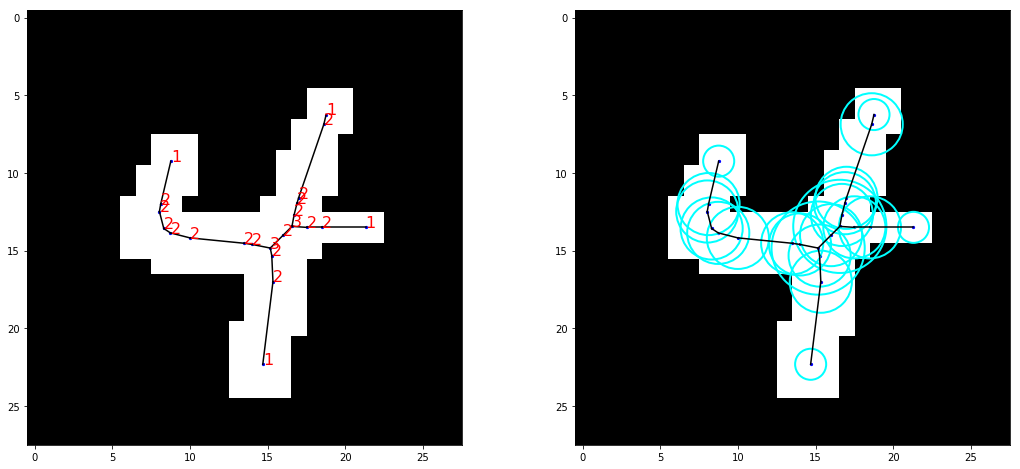

In [7]:
i = 29000
draw_skeleton(X_train[i], X_train_skel_features[i])

# CNN

In [8]:
Y_train = np_utils.to_categorical(y_train)
Y_test = np_utils.to_categorical(y_test)

In [9]:
img_rows = s
img_cols = s
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [20]:
num_classes = 10
def get_cnn():
    input1 = Input(shape = (28, 28, 1,))
    conv1 = Conv2D(64, kernel_size=(3, 3), activation='relu')(input1)
    conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(conv1)
    maxpool = MaxPooling2D(pool_size=(2, 2))(conv2)
    dp1 = Dropout(0.25)(maxpool)
    fl = Flatten()(dp1)
    d = Dense(128, activation = 'relu')(fl)
    dp2 = Dropout(0.4)(d)
    out = Dense(num_classes, activation = 'softmax')(dp2)
    model = Model(inputs = input1, outputs = out)
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
    return model

In [21]:
model = get_cnn()

epochs = 12
batch_size = 128
hist = model.fit(X_train, Y_train, epochs=epochs, verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 28s 471us/step - loss: 0.1837 - acc: 0.9446 - val_loss: 0.0609 - val_acc: 0.9813
Epoch 2/12
60000/60000 [==============================] - 28s 470us/step - loss: 0.0811 - acc: 0.9757 - val_loss: 0.0520 - val_acc: 0.9838
Epoch 3/12
60000/60000 [==============================] - 28s 462us/step - loss: 0.0622 - acc: 0.9812 - val_loss: 0.0499 - val_acc: 0.9840
Epoch 4/12
60000/60000 [==============================] - 28s 469us/step - loss: 0.0551 - acc: 0.9833 - val_loss: 0.0428 - val_acc: 0.9850
Epoch 5/12
60000/60000 [==============================] - 28s 461us/step - loss: 0.0483 - acc: 0.9852 - val_loss: 0.0442 - val_acc: 0.9857
Epoch 6/12
60000/60000 [==============================] - 28s 465us/step - loss: 0.0470 - acc: 0.9861 - val_loss: 0.0460 - val_acc: 0.9861
Epoch 7/12
60000/60000 [==============================] - 28s 470us/step - loss: 0.0434 - acc: 0.9870 - val_loss: 0.

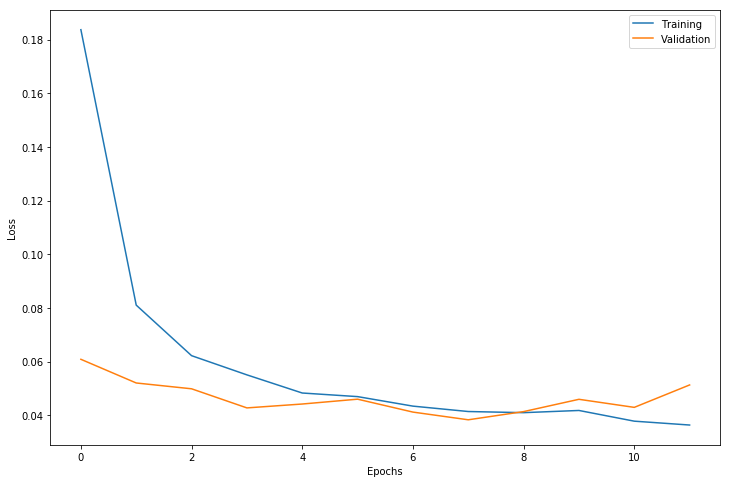

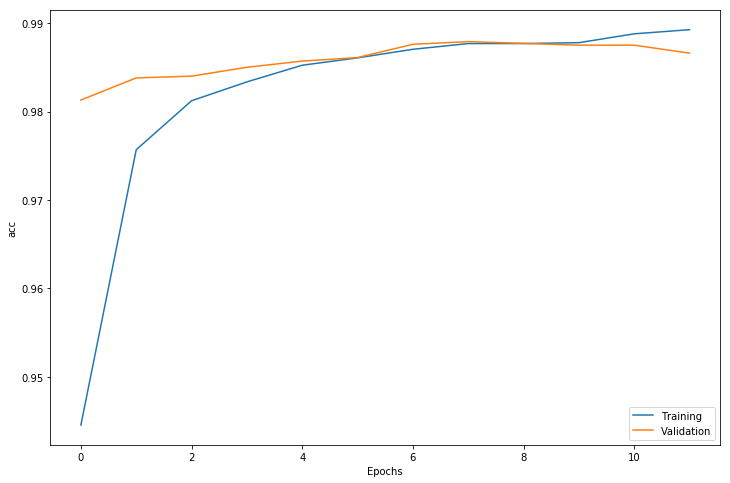

In [22]:
plt.figure(figsize=(12, 8))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.show()

plt.figure(figsize=(12, 8))
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

In [23]:
max(hist.history['val_acc']), min(hist.history['val_loss'])

(0.9879, 0.03831855364152507)

# Статистические признаки из скелетного представления

In [29]:
def get_statistic_features(skel_features):
    
    def get_arctg(x, y):
        if x == 0:
            return np.pi/2
        else:
            return np.arctan(y/x)
        
    res_x, res_y, res_deg, res_rad = get_edges_ged_rad(skel_features)
    
    res_x = np.array(res_x)
    res_y = np.array(res_y)
    
    vec_edge_x = res_x[1:]-res_x[:-1]
    vec_edge_y = res_y[1:]-res_y[:-1]
    vec_edge_l = np.sqrt(vec_edge_x**2 + vec_edge_y**2)
    vec_edge_a = [get_arctg(vec_edge_x[i], vec_edge_y[i]) for i in range(len(vec_edge_x))]
    
    x_coord = np.array([d[0] for d in res_deg])
    y_coord = np.array([d[1] for d in res_deg])
    deg = np.array([d[2] for d in res_deg])
    rad = np.array([r[2] for r in res_deg])
    
    return [np.min(vec_edge_x), np.max(vec_edge_x), np.mean(vec_edge_x), np.std(vec_edge_x), 
            np.min(vec_edge_y), np.max(vec_edge_y), np.mean(vec_edge_y), np.std(vec_edge_y),
            np.min(vec_edge_l), np.max(vec_edge_l), np.mean(vec_edge_l), np.std(vec_edge_l),
            np.min(vec_edge_a), np.max(vec_edge_a), np.mean(vec_edge_a), np.std(vec_edge_a),
            np.min(x_coord), np.max(x_coord), np.mean(x_coord), np.std(x_coord),
            np.min(y_coord), np.max(y_coord), np.mean(y_coord), np.std(y_coord),
            deg[deg==1].size, deg[deg==2].size, deg[deg==3].size,
            np.min(rad), np.max(rad), np.mean(rad), np.std(rad)]

In [38]:
X_train_skel = []
for x_sk in tqdm(X_train_skel_features):
    X_train_skel.append(get_statistic_features(x_sk))
X_train_skel = np.array(X_train_skel)
    
X_test_skel = []
for x_sk in tqdm(X_test_skel_features):
    X_test_skel.append(get_statistic_features(x_sk))
X_test_skel = np.array(X_test_skel)

100%|██████████| 10000/10000 [00:05<00:00, 1934.84it/s]


In [41]:
clf = xgb.XGBClassifier()
clf.fit(X_train_skel, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [49]:
y_pred = clf.predict(X_test_skel)

accuracy_score(y_test, y_pred)

/home/alex/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8807

# Объеденим статистические признаки со сверточной нейронной сетью

In [50]:
X_train_skel.shape

(60000, 31)

In [69]:
num_classes = 10
def get_cnn():
    input1 = Input(shape = (28, 28, 1,))
    conv1 = Conv2D(64, kernel_size=(3, 3), activation='relu')(input1)
    conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(conv1)
    maxpool = MaxPooling2D(pool_size=(2, 2))(conv2)
    dp1 = Dropout(0.25)(maxpool)
    fl = Flatten()(dp1)
    input2 = Input(shape = (31, ))
    conc = concatenate([fl, input2], axis = -1)
    d = Dense(256, activation = 'relu')(conc)
    dp2 = Dropout(0.5)(d)
    out = Dense(num_classes, activation = 'softmax')(dp2)
    model = Model(inputs = [input1, input2], outputs = out)
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
    return model

In [75]:
model = get_cnn()

epochs = 20
batch_size = 128
hist = model.fit([X_train, X_train_skel], Y_train, epochs=epochs, verbose=1, 
                 validation_data=([X_test, X_test_skel], Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 35s 588us/step - loss: 0.2086 - acc: 0.9362 - val_loss: 0.0684 - val_acc: 0.9783
Epoch 2/20
60000/60000 [==============================] - 35s 580us/step - loss: 0.0978 - acc: 0.9708 - val_loss: 0.0527 - val_acc: 0.9840
Epoch 3/20
60000/60000 [==============================] - 35s 584us/step - loss: 0.0765 - acc: 0.9769 - val_loss: 0.0587 - val_acc: 0.9835
Epoch 4/20
60000/60000 [==============================] - 35s 585us/step - loss: 0.0704 - acc: 0.9790 - val_loss: 0.0515 - val_acc: 0.9852
Epoch 5/20
60000/60000 [==============================] - 35s 585us/step - loss: 0.0627 - acc: 0.9816 - val_loss: 0.0506 - val_acc: 0.9850
Epoch 6/20
60000/60000 [==============================] - 35s 587us/step - loss: 0.0601 - acc: 0.9820 - val_loss: 0.0502 - val_acc: 0.9844
Epoch 7/20
60000/60000 [==============================] - 35s 590us/step - loss: 0.0559 - acc: 0.9838 - val_loss: 0.

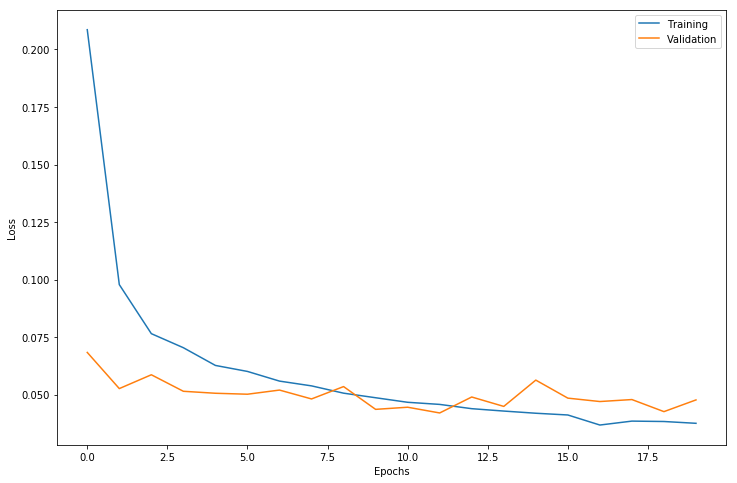

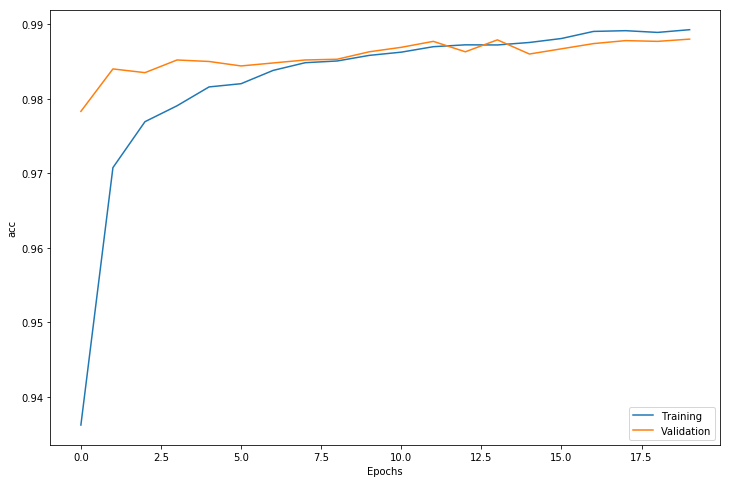

In [76]:
plt.figure(figsize=(12, 8))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.show()

plt.figure(figsize=(12, 8))
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

In [77]:
max(hist.history['val_acc']), min(hist.history['val_loss'])

(0.988, 0.04206943803685053)